In [1]:
!pip install cfgrib pandas ecmwf-api-client metview xarray


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datetime import datetime, timedelta
from ecmwfapi import ECMWFDataServer
import pandas as pd
import cfgrib
import os
import xarray as xr

# ECMWF DATA

# 1. Data Retrieval



### Generate Dates for Retrieval

In [3]:
# Function to generate all Mondays and Thursdays within a date range
def generate_forecast_dates(start_year, end_year):
    start_date = datetime(start_year, 1, 1)  # Start from January 1 of the start year
    end_date = datetime(end_year, 12, 31)   # End at December 31 of the end year
    forecast_dates = []

    while start_date <= end_date:
        # Check if the date is Monday (0) or Thursday (3)
        if start_date.weekday() in [0, 3]:
            forecast_dates.append(start_date.strftime("%Y-%m-%d"))
        start_date += timedelta(days=1)

    return "/".join(forecast_dates)  # Join dates as a string separated by "/"

# Generate dates
formatted_dates = generate_forecast_dates(2016, 2021)
print("Generated dates:", formatted_dates)

Generated dates: 2016-01-04/2016-01-07/2016-01-11/2016-01-14/2016-01-18/2016-01-21/2016-01-25/2016-01-28/2016-02-01/2016-02-04/2016-02-08/2016-02-11/2016-02-15/2016-02-18/2016-02-22/2016-02-25/2016-02-29/2016-03-03/2016-03-07/2016-03-10/2016-03-14/2016-03-17/2016-03-21/2016-03-24/2016-03-28/2016-03-31/2016-04-04/2016-04-07/2016-04-11/2016-04-14/2016-04-18/2016-04-21/2016-04-25/2016-04-28/2016-05-02/2016-05-05/2016-05-09/2016-05-12/2016-05-16/2016-05-19/2016-05-23/2016-05-26/2016-05-30/2016-06-02/2016-06-06/2016-06-09/2016-06-13/2016-06-16/2016-06-20/2016-06-23/2016-06-27/2016-06-30/2016-07-04/2016-07-07/2016-07-11/2016-07-14/2016-07-18/2016-07-21/2016-07-25/2016-07-28/2016-08-01/2016-08-04/2016-08-08/2016-08-11/2016-08-15/2016-08-18/2016-08-22/2016-08-25/2016-08-29/2016-09-01/2016-09-05/2016-09-08/2016-09-12/2016-09-15/2016-09-19/2016-09-22/2016-09-26/2016-09-29/2016-10-03/2016-10-06/2016-10-10/2016-10-13/2016-10-17/2016-10-20/2016-10-24/2016-10-27/2016-10-31/2016-11-03/2016-11-07/2016

### Connecting to API and retrieving data

In [7]:
# Get the current user's home directory
home_dir = os.path.expanduser("~")
credentials_path = os.path.join(home_dir, ".ecmwfapirc")

# Save my ECMWF API credentials to the .ecmwfapirc file
api_key = """
{
    "url": "https://api.ecmwf.int/v1",
    "key": "3e1bf21fc8841ec617c587e95d8694fd",
    "email": "khokhlovamariy@gmail.com"
}
"""

# Write the credentials to the file
with open(credentials_path, "w") as file:
    file.write(api_key)

print(f"ECMWF API credentials saved to {credentials_path}")

ECMWF API credentials saved to C:\Users\Мария\.ecmwfapirc


In [8]:
server = ECMWFDataServer()

In [9]:
server.retrieve({
    "class": "s2",                       # Subseasonal-to-seasonal forecasts
    "dataset": "s2s",                    # S2S dataset
    "date": formatted_dates,             # Dates
    "expver": "prod",                    # Production version
    "levtype": "sfc",                    # Surface level data
    "model": "glob",                     # Global model
    "area": "73.5/-27/33/45",
    "origin": "ecmf",                    # ECMWF origin
    "param": "167",                      # t2m
    "step": "504-528/528-552/552-576/576-600/600-624/624-648/648-672/672-696/696-720/720-744/744-768/768-792/792-816/816-840", # Steps for subseasonal forecast
    "stream": "enfo",                    # Ensemble forecast stream
    "time": "00:00:00",                  # Initial forecast time
    "type": "cf",                        # Control forecast
    "target": "data/subseasonal_output.grib"  # Output file
})

2025-01-14 01:25:45 ECMWF API python library 1.6.3
2025-01-14 01:25:45 ECMWF API at https://api.ecmwf.int/v1
2025-01-14 01:25:46 Welcome Mariia Khokhlova
2025-01-14 01:25:46 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2025-01-14 01:25:46 ------------ WARNING ------------
2025-01-14 01:25:46 Access to this dataset is transitioning to a new interface, dates to be announced soon
2025-01-14 01:25:46 For more information on how to access this data in the future, visit https://confluence.ecmwf.int/x/-wUiEw
2025-01-14 01:25:46 ---------------------------------
2025-01-14 01:25:46 Request submitted
2025-01-14 01:25:46 Request id: 6785af099c230944f2a45c0d
2025-01-14 01:25:46 Request is submitted
2025-01-14 01:25:48 Calling 'nice mars /tmp/20250114-0020/35/tmp-_mars-uOW3i3.req'
2025-01-14 01:25:48 Forcing MIR_CACHE_PATH=/data/ec_coeff
2025-01-14 01:25:48 mars - WARN -
2025-01-14 01:25:48 mars - WARN -
2025-01-14 01:25

# First look at data

In [7]:
# Open the GRIB file using xarray with the cfgrib engine
ds = xr.open_dataset("data/subseasonal_output.grib", engine="cfgrib")

# Inspect the dataset
print(ds)
print("Dimensions:", ds.dims)  # Displays dimensions (e.g., time, latitude, longitude, etc.)
print("Coordinates: ", ds.coords)  # Displays coordinate variables (e.g., time, lat, lon)

# Check variable names
print("Variables:", list(ds.data_vars))

<xarray.Dataset> Size: 48MB
Dimensions:            (time: 626, step: 14, latitude: 28, longitude: 49)
Coordinates:
    number             int32 4B ...
  * time               (time) datetime64[ns] 5kB 2016-01-04 ... 2021-12-30
  * step               (step) timedelta64[ns] 112B 22 days 23 days ... 35 days
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 224B 73.5 72.0 70.5 ... 36.0 34.5 33.0
  * longitude          (longitude) float64 392B -27.0 -25.5 -24.0 ... 43.5 45.0
    valid_time         (time, step) datetime64[ns] 70kB ...
Data variables:
    t2m                (time, step, latitude, longitude) float32 48MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-21T22

In [8]:
first_date_first_step_valid_time = ds['valid_time'].isel(time=0, step=0).values
print(f"Valid time for the first date and first step: {first_date_first_step_valid_time}")

Valid time for the first date and first step: 2016-01-26T00:00:00.000000000


Dimensions:
* time: Forecast initialization times (2016-01-04 to 2021-12-30).
* step: Steps (for subseasonal predictions from 3 to 5 weeks).
* latitude and longitude: The grid of geographic points.

valid_time: The actual date corresponding to each forecast step.

In [12]:
# Convert 'step' to days for easier interpretation
step_days = ds.coords['step'].dt.days

# Find the index of the exact step (e.g., 22 days)
target_step = 22  # Example step in days
step_index = step_days.values.tolist().index(target_step)

# Extract rows for the exact step
exact_step_data = ds.isel(step=step_index)

# Print the rows for the exact step
print(exact_step_data)

<xarray.Dataset> Size: 3MB
Dimensions:            (time: 626, latitude: 28, longitude: 49)
Coordinates:
    number             int32 4B ...
  * time               (time) datetime64[ns] 5kB 2016-01-04 ... 2021-12-30
    step               timedelta64[ns] 8B 22 days
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 224B 73.5 72.0 70.5 ... 36.0 34.5 33.0
  * longitude          (longitude) float64 392B -27.0 -25.5 -24.0 ... 43.5 45.0
    valid_time         (time) datetime64[ns] 5kB ...
Data variables:
    t2m                (time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-21T22:29 GRIB to CDM+CF via cfgrib-0.9.1...


In [17]:
vienna_t2m = ds['t2m'].isel(step=step_index).sel(
    latitude=vienna_lat, longitude=vienna_lon, method='nearest'
)

# Convert temperature to Celsius
vienna_t2m_celsius = vienna_t2m - 273.15

# Print the temperature in Celsius
print("Temperature values in Celsius for Vienna (22-day forecast step):")
print(vienna_t2m_celsius.values)

Temperature values in Celsius for Vienna (22-day forecast step):
[ -0.8155823   -1.3974304    1.4526672    0.0329895    3.8223572
   3.3049622    3.1662292   -0.83303833   2.49411      5.2707825
   5.2201233    3.9675598    3.268402     1.459259     3.8459778
   0.7679138    9.990082     1.5393982    6.5646057    3.2215881
   8.311859     6.6462708   12.85849     10.36441     13.212982
  13.703949     8.330658    13.594696    12.376251    12.561005
  13.739166    20.609161    16.95523     17.350006     9.573334
  16.520844    17.266754    22.4581      17.444977    19.278961
  15.580475    25.118134    14.731659    25.211761    18.3815
  22.597382    18.389374    25.12387     22.193695    23.32846
  19.570404    22.598846    24.243378    17.611603    19.55606
  30.276031    20.879303    21.327911    25.094452    26.714996
  24.606354    20.39804     17.151886    21.151031    18.753693
  18.89682     17.420197    17.01474     14.541046    15.110992
  15.982574    15.129547    16.513824  

In [18]:
# Create a new variable for Celsius temperatures in the dataset
ds['t2m_celsius'] = ds['t2m'] - 273.15

# Verify the conversion
print(ds['t2m_celsius'])

<xarray.DataArray 't2m_celsius' (time: 626, step: 14, latitude: 28,
                                 longitude: 49)> Size: 48MB
array([[[[-2.17784729e+01, -1.78351135e+01, -1.57901917e+01, ...,
          -3.42886353e+00, -3.34683228e+00, -4.13198853e+00],
         [-2.63097229e+01, -2.34874573e+01, -1.96749573e+01, ...,
          -2.68276978e+00, -2.46987915e+00, -2.72573853e+00],
         [-2.17667542e+01, -1.33839417e+01, -1.06437073e+01, ...,
          -3.54409790e+00, -2.39175415e+00, -2.40151978e+00],
         ...,
         [ 1.62117615e+01,  1.62586365e+01,  1.63387146e+01, ...,
           7.70394897e+00,  7.09457397e+00,  1.53988647e+00],
         [ 1.70906677e+01,  1.69910583e+01,  1.69363708e+01, ...,
           9.64144897e+00,  9.40121460e+00,  9.14535522e+00],
         [ 1.77039490e+01,  1.76512146e+01,  1.75086365e+01, ...,
           8.82113647e+00,  1.04871521e+01,  1.12000427e+01]],

        [[-1.58551331e+01, -1.30016174e+01, -1.14293518e+01, ...,
          -3.58755493e

<Axes: title={'center': 'Temperature Forecast for Vienna'}, xlabel='time'>

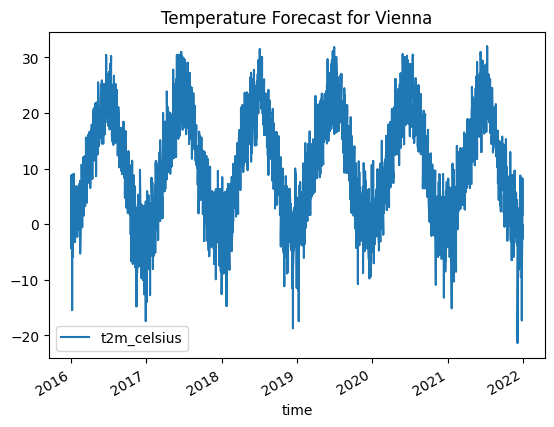

In [21]:
# Select a specific location (e.g., Vienna, lat=48.2, lon=16.4)
vienna_temperature = ds["t2m_celsius"].sel(latitude=48.2, longitude=16.4, method="nearest")

# Convert to Pandas DataFrame and plot
vienna_df = vienna_temperature.to_dataframe().reset_index()
vienna_df.plot(x="time", y="t2m_celsius", title="Temperature Forecast for Vienna")

# ecPoint